In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import itertools
from itertools import product
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pylab as plt
plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

# DICKEY FULLER TEST
from statsmodels.tsa.stattools import adfuller
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")


def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ###################################
        # DICKEY FULLER
        # x(t)=rho*x(t−1)+e(t)
        # 
        #### as we increase the rho value the deviation of time series increases
        #### around its mean value
        #
        #### for rho=1 there will be nothing that will bring x(t) to its mean value
        #### back once it reaches the critical value and hence time series become
        #### non stationary. for this first difference will make series stationary 
        #
        # for details look medium tutorial file
        ###################################
        adf_test(y)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, ax=acf_ax)
        plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
    

def getBestOrder(parameters_list, train, test):
    """
        Return dataframe with parameters and corresponding AIC, RMSE
        
        parameters_list - list with (p, q, q, P, D, Q, S) tuples
        train- series to train model
        test- series to test model
    """
    # one with lowest aic and bic should be the choice
    results = []
    best_rmse=float("inf")

    for param in tqdm_notebook(parameters_list):
            try:
                model = SARIMAX(train,
                              order=(param[0], param[1], param[2]),
                              seasonal_order=(param[3], param[4], param[5], param[6]),
                              enforce_stationarity=False,
                              enforce_invertibility=False).fit(disp=False)
                forecast = model.forecast(len(test))
                rmse = np.sqrt(mean_squared_error(forecast, test))
                print('ARIMA{} - AIC:{} - RMSE:{}'.format(param, model.aic, rmse))
        
                if best_rmse>rmse:
                    best_params = param
                    best_rmse=rmse
                results.append([param, model.aic, rmse])
            except:
                continue

    print("RMSE- {}\nBest p,d,q, P,D,Q,S- {}".format(best_rmse, best_params))
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic', 'rmse']

    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='rmse', ascending=True).reset_index(drop=True)
    
    return result_table


### AR(p) - autoregression model
 Regression of the time series onto itself.<br>
 Current series values depend on its previous values with some lag. The maximum 
 lag in the model is referred to as p. To determine the initial p you need to 
 have a look at PACF plot — find the biggest significant lag, after which most 
 other lags are becoming insignificant.
 
### MA(q) — moving average model
 It models the error of the time series or residual.<br>
 Current error depends on the previous with some lag, which is referred to as q. <br>
 Initial value can be found on ACF plot with the same logic.

### I(d) - order of integration
 It is simply the number of nonseasonal differences needed for making the 
 series stationary.

### S(s)- responsible for seasonality and hence equals to season of a series
### P- order of autoregression for seasonal component
 Can be derived from PACF, but this time you need to look at the number of 
 significant lags, which are the multiples of the season period length, for 
 example, if the period equals 24 and looking at PACF we see 24th and 48th 
 lags are significant, that means initial P should be 2.
 
### Q- Same logic, but for the moving average model of the seasonal component use ACF plot
### D - order of seasonal integration
 Can be equal to 1 or 0, depending on whether seasonal differences were 
 applied or not


In [7]:
df1 = pd.read_csv('data/airline_passengers.csv', parse_dates=True, index_col='Month')
df1.index.freq = 'MS'
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Thousands of Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


Augmented Dickey-Fuller Test: 
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


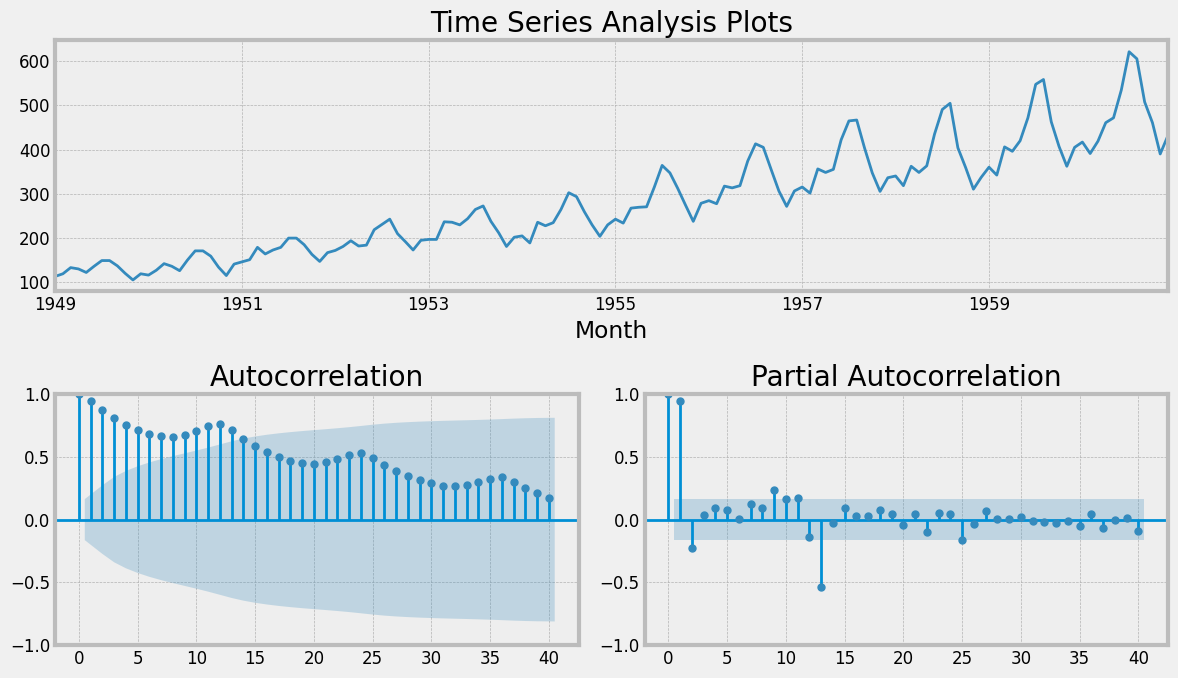

In [13]:
# check data & stationarity
tsplot(df1['Thousands of Passengers'], lags=40)
#df1.plot(figsize=(8,4))

determine model parameters<br>
#########################################################<br>
&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;ACF&ensp;&ensp;&ensp;&ensp; &ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;PACF<br>
AR&ensp;&ensp;&ensp;&ensp;&ensp;geometric(gradual decrease)&ensp;&ensp;&ensp;&ensp;significant till p lags<br>
MA&ensp;&ensp;&ensp;&ensp;&nbsp;significant till p lags&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&nbsp;geometric<br>
ARMA&ensp;&ensp;geometric&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;&ensp;geometric<br>
###########################################################<br>
nlags: number of samples for autocorrelation to be returned for autocorrelation 

In [12]:
# stationarity check
df1['d1'] = diff(df1['Thousands of Passengers'], k_diff=1)
adf_test(df1['d1'])
# trend is removed but not stationary
print()
df1['d2'] = diff(df1['Thousands of Passengers'], k_diff=2)
adf_test(df1['d2'])
# series becomes stationary

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.829267
p-value                   0.054213
# lags used              12.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.638423e+01
p-value                 2.732892e-29
# lags used             1.100000e+01
# observations          1.300000e+02
critical value (1%)    -3.481682e+00
critical value (5%)    -2.884042e+00
critical value (10%)   -2.578770e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


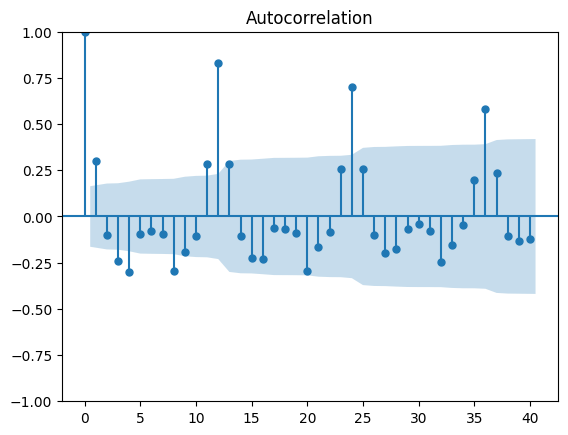

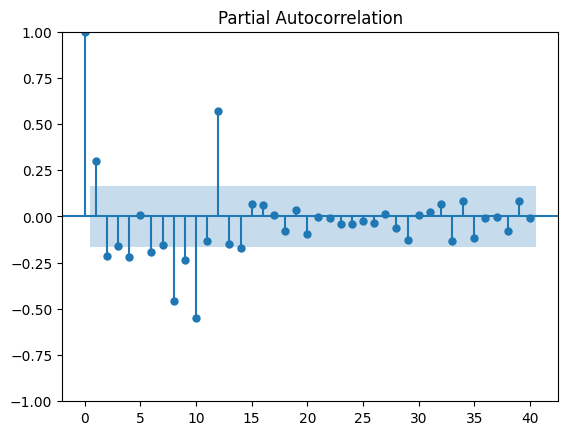

In [5]:
plot_acf(df1['Thousands of Passengers'].diff(1)[1:], lags=40);
plot_pacf(df1['Thousands of Passengers'].diff(1)[1:], lags=40);

### FROM ACF-<br>
1. suggests seasonality period=12, hence S=12
3. significat lag at 1 so q=1

### FROM PACF-<br>
1. significant lag at 1 so p=1
2. lag is significant at S=12, hence P=1 and Q=0

                                      SARIMAX Results                                      
Dep. Variable:             Thousands of Passengers   No. Observations:                   96
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 12)   Log Likelihood                -301.699
Date:                             Wed, 17 Apr 2024   AIC                            611.398
Time:                                     10:13:52   BIC                            621.025
Sample:                                 01-01-1949   HQIC                           615.264
                                      - 12-01-1956                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0007      0.295      0.002      0.998      -0.578       0.579
ma.L1         -0.3659      

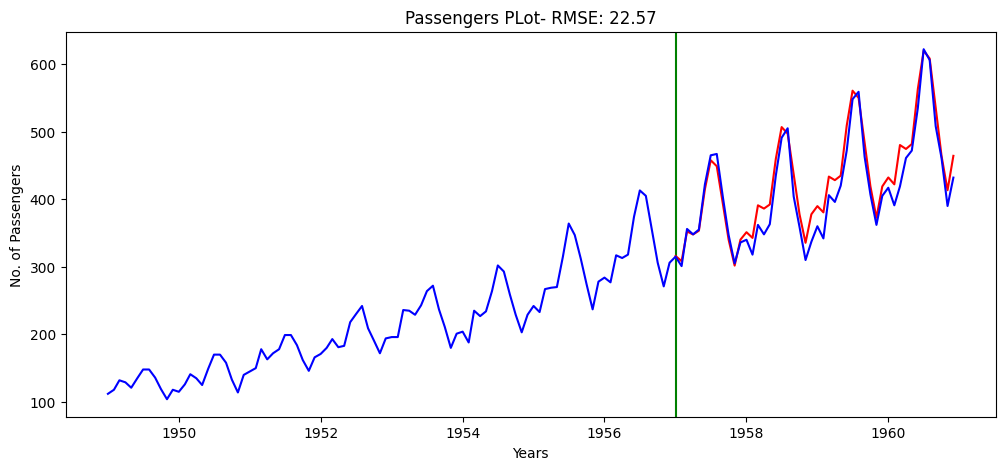

In [33]:
train = df1['Thousands of Passengers'].iloc[:-48]
test = df1['Thousands of Passengers'].iloc[-48:]

# train and fit model
# order = p,d,q- 1,1,1
# seasonal order = P,D,Q,S- 1,0,0,12
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,0,0,12), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

# define no. of forecasts to be done
K = len(test)

# make forecasts
forecast = model_fit.forecast(K)

plt.figure(figsize=(12,5))
plt.xlabel("Years")
plt.ylabel("No. of Passengers")
plt.title("Passengers PLot- RMSE: %.2f"%np.sqrt(sum((forecast-test)**2)/len(test)))
plt.axvline(x=df1.index[-48], color='green')
plt.plot(forecast, 'r')
plt.plot(df1, 'b')
print('RMSE-', np.sqrt(mean_squared_error(test, forecast)))


In [30]:
ps = range(0, 2)
d=[1] 
qs = range(0, 2)
Ps = range(0, 2)
D=[1] 
Qs = range(0, 2)
s = [12] # season length is still 1
# creating list with all the possible combinations of parameters
parameters = product(ps, d, qs, Ps, D, Qs, s)
parameters_list = list(parameters)
print(len(parameters_list))

result_table = getBestOrder(parameters_list, train, test)
# best order gives rmse of 20 approx

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1301.7158787856208 - RMSE:420.7120699876976
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1069.8681142508224 - RMSE:391.7820688752563
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:817.6023833571672 - RMSE:97.80092450142449
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:678.6537300240175 - RMSE:87.93496958544009
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:677.5531509102017 - RMSE:61.498815026914954
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:647.7939382090095 - RMSE:57.69740596637343
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:654.034749541508 - RMSE:25.363334392537496
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:606.5519478528666 - RMSE:50.81198475829731
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1167.8912769953188 - RMSE:418.7091218868182
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:953.0565437830908 - RMSE:389.7310282047437
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:738.7752929519104 - RMSE:97.116283757628
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:625.0533806672252 - RMSE:87.77488402016775
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:6

## dataset 2

2014-01-06 00:00:00 2017-12-30 00:00:00
Order Date    0
Sales         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2014-01-01 to 2017-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes
None
Augmented Dickey-Fuller Test: 
ADF test statistic      -4.727837
p-value                  0.000075
# lags used              0.000000
# observations          47.000000
critical value (1%)     -3.577848
critical value (5%)     -2.925338
critical value (10%)    -2.600774
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


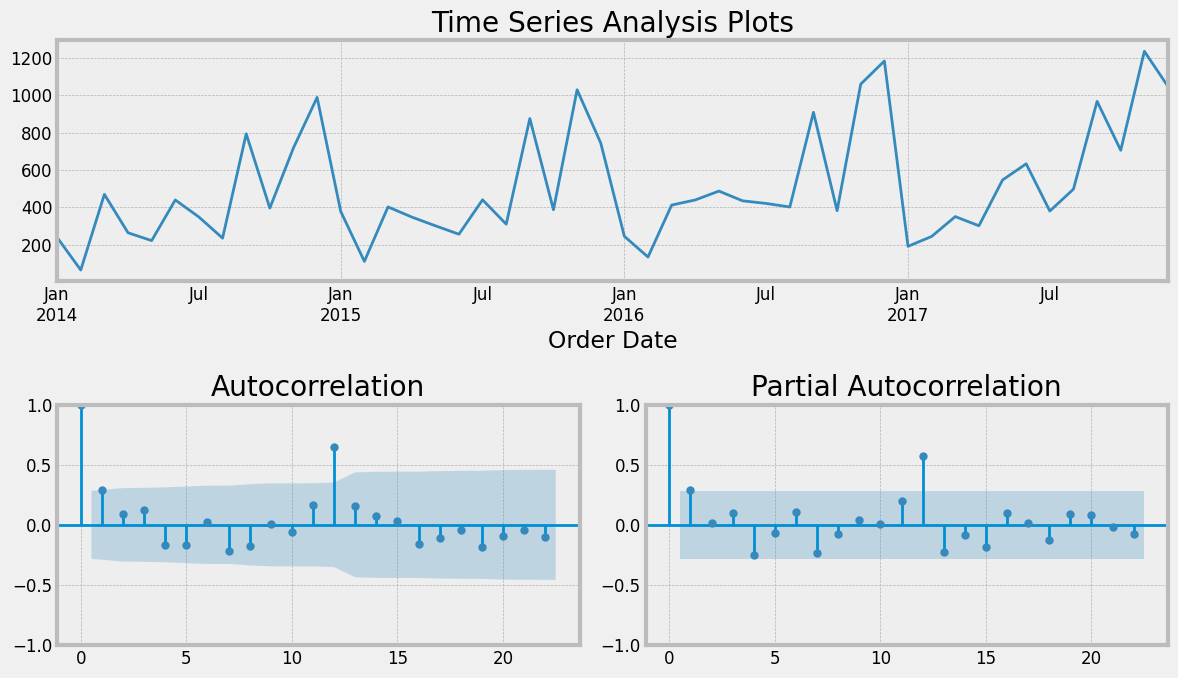

In [16]:
df2 = pd.read_excel("data/Superstore.xls")

# fetch only furniture data
furniture = df2.loc[df2['Category'] == 'Furniture']

# print minimum date and maximum date of furniture data
print(furniture['Order Date'].min(), furniture['Order Date'].max())

# drop all the columns which are not required to predict sales
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 
        'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 
        'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 
        'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)

# sort based on order date
furniture = furniture.sort_values('Order Date')

# check null values
print(furniture.isnull().sum())

# set index to order date & sum sales across a day
furniture = furniture.set_index('Order Date')
furniture = furniture.resample('D').sum()

# take monthly average
# 'MS' for month start
df2 = pd.DataFrame()
df2['Sales'] = furniture['Sales'].resample('MS').mean()
print(df2.info())

# plot data
#df2.plot(figsize=(15, 6))
tsplot(df2['Sales'], lags=22)

S=12, p=1, q=1, P=1, Q=1

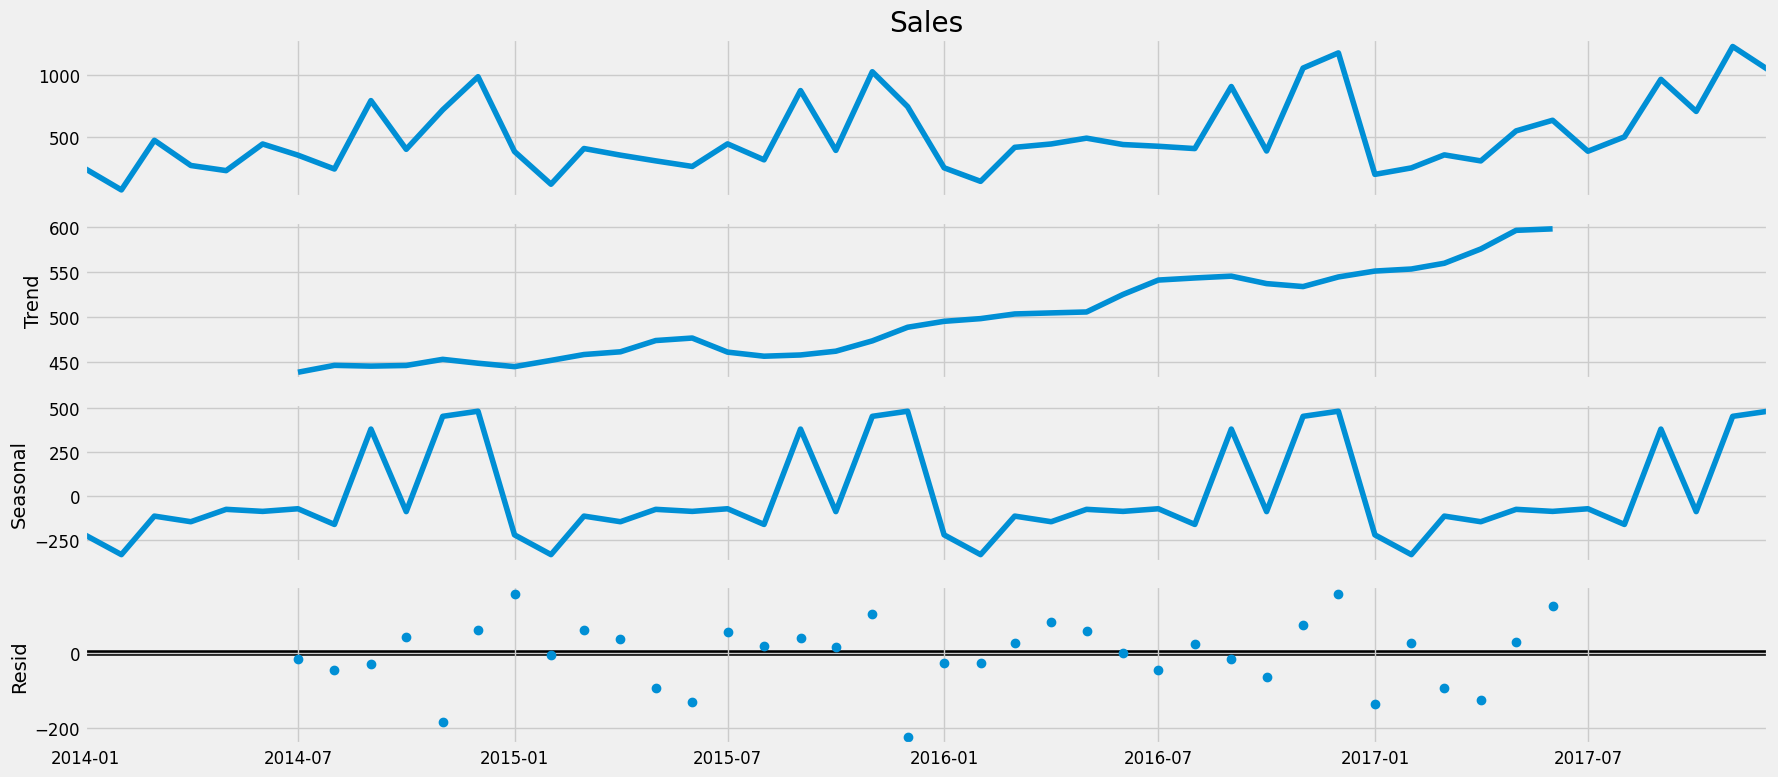

In [69]:
# plot data for trend and seasonality
decomposition = sm.tsa.seasonal_decompose(df2['Sales'], model='additive')
fig = decomposition.plot()

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   36
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -137.566
Date:                            Thu, 25 Apr 2024   AIC                            285.132
Time:                                    09:47:34   BIC                            290.588
Sample:                                01-01-2014   HQIC                           286.417
                                     - 12-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5740      0.584      0.983      0.326      -0.570       1.718
ma.L1         -0.9167      1.041   

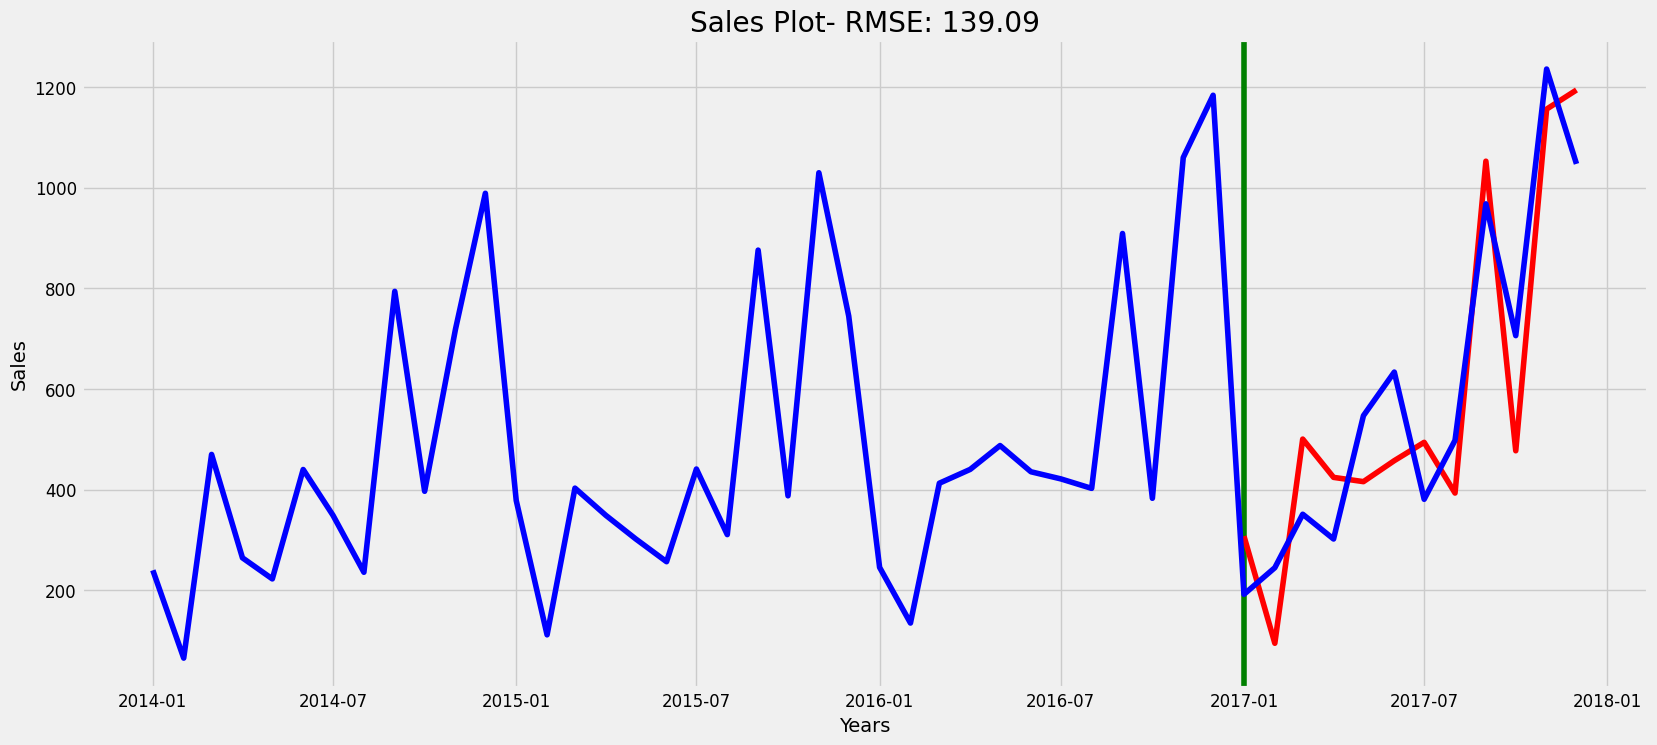

In [28]:
train = df2['Sales'].iloc[:-12]
test = df2['Sales'].iloc[-12:]

# train and fit model
# order = p,d,q- 1,0,1
# seasonal order = P,D,Q,S- 1,0,1,12
model = SARIMAX(train, order=(1,0,1), seasonal_order=(1,0,1,12), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

# define no. of forecasts to be done
K = len(test)

# make forecasts
forecast = model_fit.forecast(K)

plt.xlabel("Years")
plt.ylabel("Sales")
plt.title("Sales Plot- RMSE: %.2f"%np.sqrt(sum((forecast-test)**2)/len(test)))
plt.axvline(x=df2.index[-12], color='green')
plt.plot(forecast, 'r')
plt.plot(df2['Sales'], 'b')
print('RMSE-', np.sqrt(mean_squared_error(test, forecast)))


In [78]:
ps = range(0, 2)
d=[1] 
qs = range(0, 2)
Ps = range(0, 2)
D=[1] 
Qs = range(0, 2)
s = [12] # season length is still 1
# creating list with all the possible combinations of parameters
parameters = product(ps, d, qs, Ps, D, Qs, s)
parameters_list = list(parameters)
print(len(parameters_list))

result_table = getBestOrder(parameters_list, train, test)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:544.753402037633 - RMSE:674.6862802661467
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:349.0710025543812 - RMSE:429.332241515422
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:298.1446686729391 - RMSE:143.8996897797409
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:145.02400154315134 - RMSE:164.36792755727438
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:310.6937939324797 - RMSE:141.23271745650584
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:293.97052187916063 - RMSE:143.13297146764253
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:156.90039986935716 - RMSE:161.50773663805307
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:145.73745349492393 - RMSE:141.79403027054784
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:514.8287779231705 - RMSE:673.3472525650678
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:327.16222069403693 - RMSE:427.71365119726164
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:288.14689749447774 - RMSE:143.5602918242704
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:128.58250629713555 - RMSE:190.9718809124889
ARIMA(0, 0, 1)x(1, 0, 0, 12)1

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   36
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 12)   Log Likelihood                -135.415
Date:                             Wed, 17 Apr 2024   AIC                            276.830
Time:                                     10:44:06   BIC                            279.963
Sample:                                 01-01-2014   HQIC                           277.510
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1349      0.267     -0.506      0.613      -0.658       0.388
ma.L1         -0.9874      

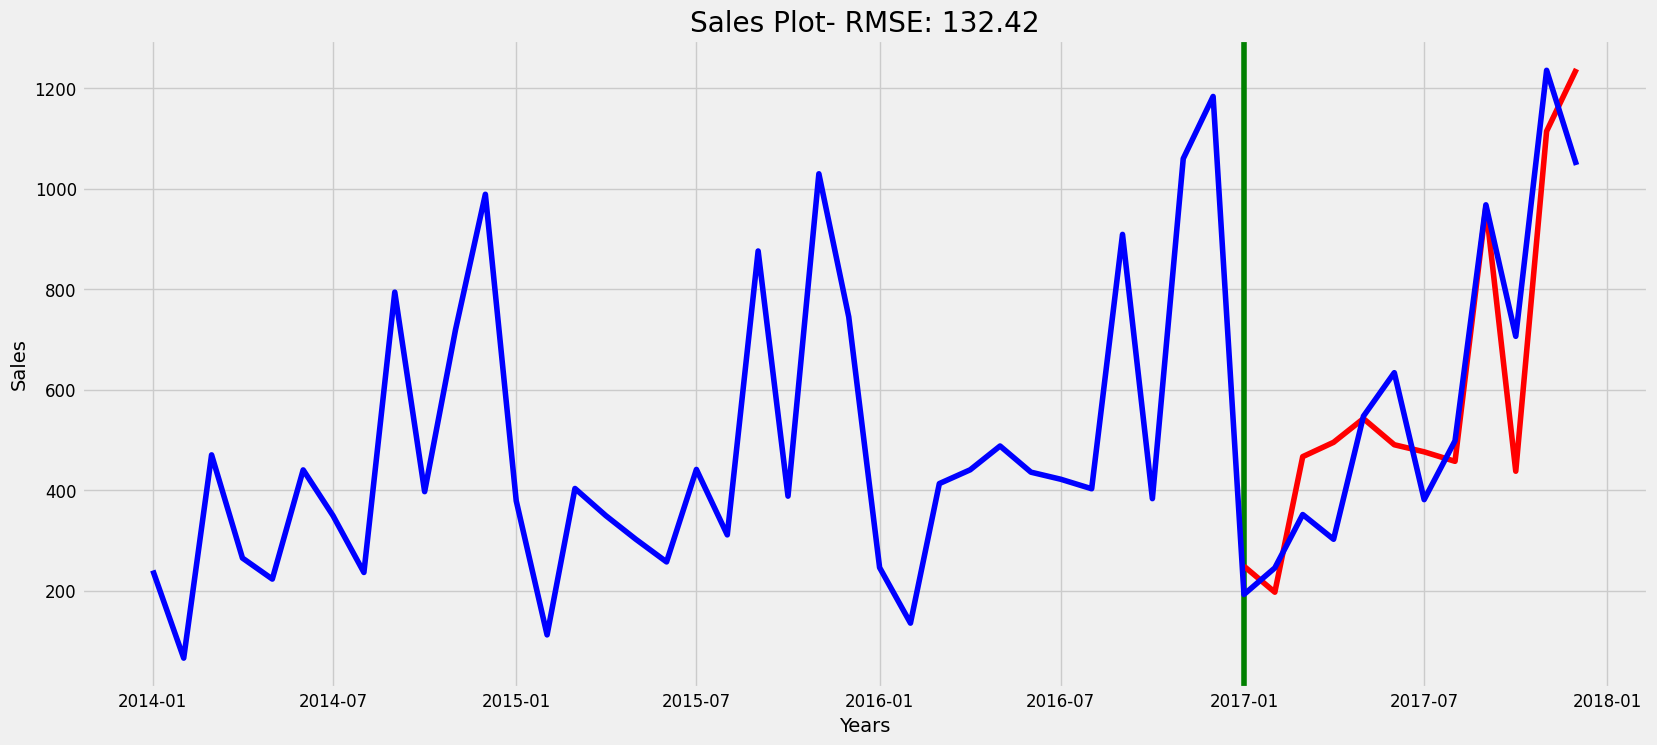

In [79]:
model = SARIMAX(train, order=(1,1,1), seasonal_order=(0,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

# define no. of forecasts to be done
K = len(test)

# make forecasts
forecast = model_fit.forecast(K)

plt.xlabel("Years")
plt.ylabel("Sales")
plt.title("Sales Plot- RMSE: %.2f"%np.sqrt(sum((forecast-test)**2)/len(test)))
plt.axvline(x=df2.index[-12], color='green')
plt.plot(forecast, 'r')
plt.plot(df2['Sales'], 'b')
print('RMSE-', np.sqrt(mean_squared_error(test, forecast)))


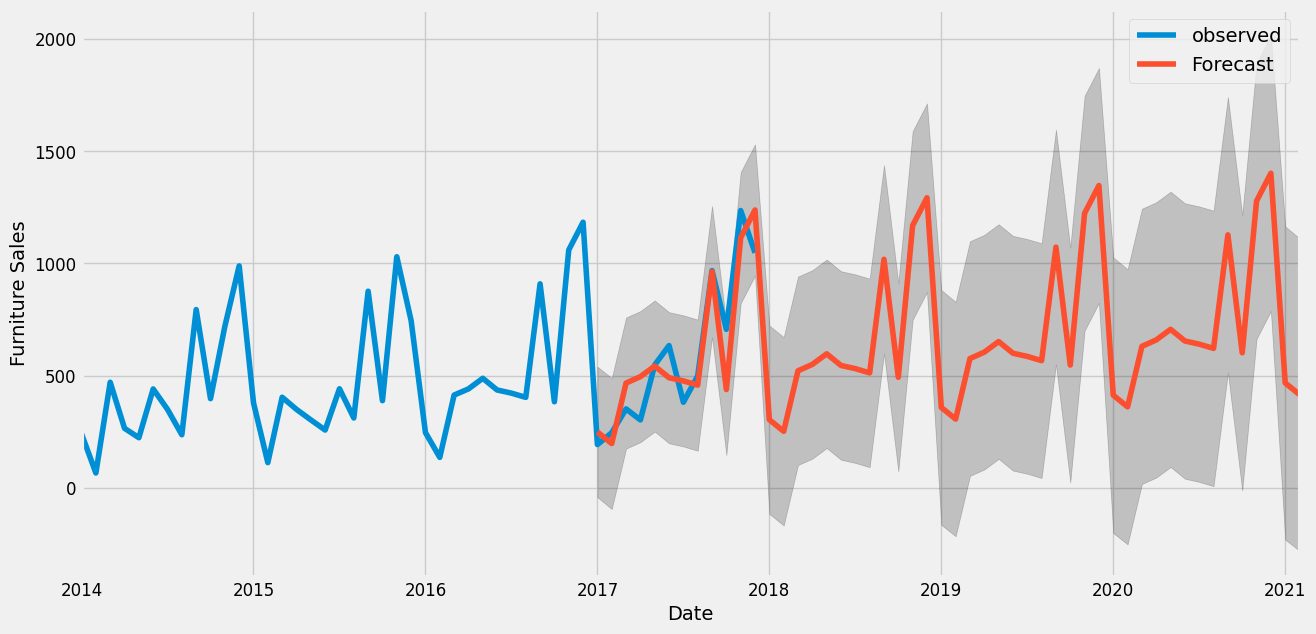

In [92]:
pred_uc = model_fit.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = df2['Sales'].plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

## dataset 3

In [32]:
data = pd.read_excel("data/Superstore.xls")
data[data.Category=='Office Supplies'][['Order Date', 'Sales']]
data.set_index('Order Date', inplace=True)
df3 = pd.DataFrame()
df3['Sales'] = data['Sales'].resample('MS').sum()
df3.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2014-01-01 to 2017-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   48 non-null     float64
dtypes: float64(1)
memory usage: 768.0 bytes


Augmented Dickey-Fuller Test: 
ADF test statistic      -4.493768
p-value                  0.000202
# lags used              0.000000
# observations          47.000000
critical value (1%)     -3.577848
critical value (5%)     -2.925338
critical value (10%)    -2.600774
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


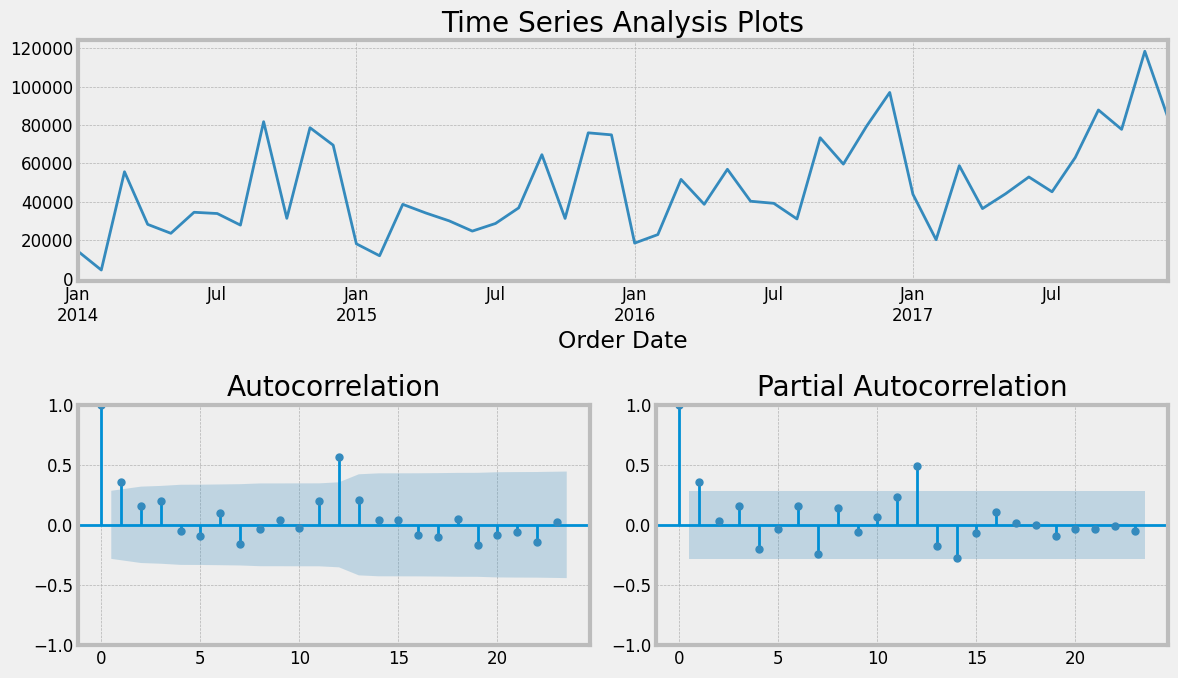

In [33]:
# plot data
tsplot(df3['Sales'], lags=23)
#df3.plot(figsize=(15, 6))

S=12, p=1, q=1, P=1, Q=1

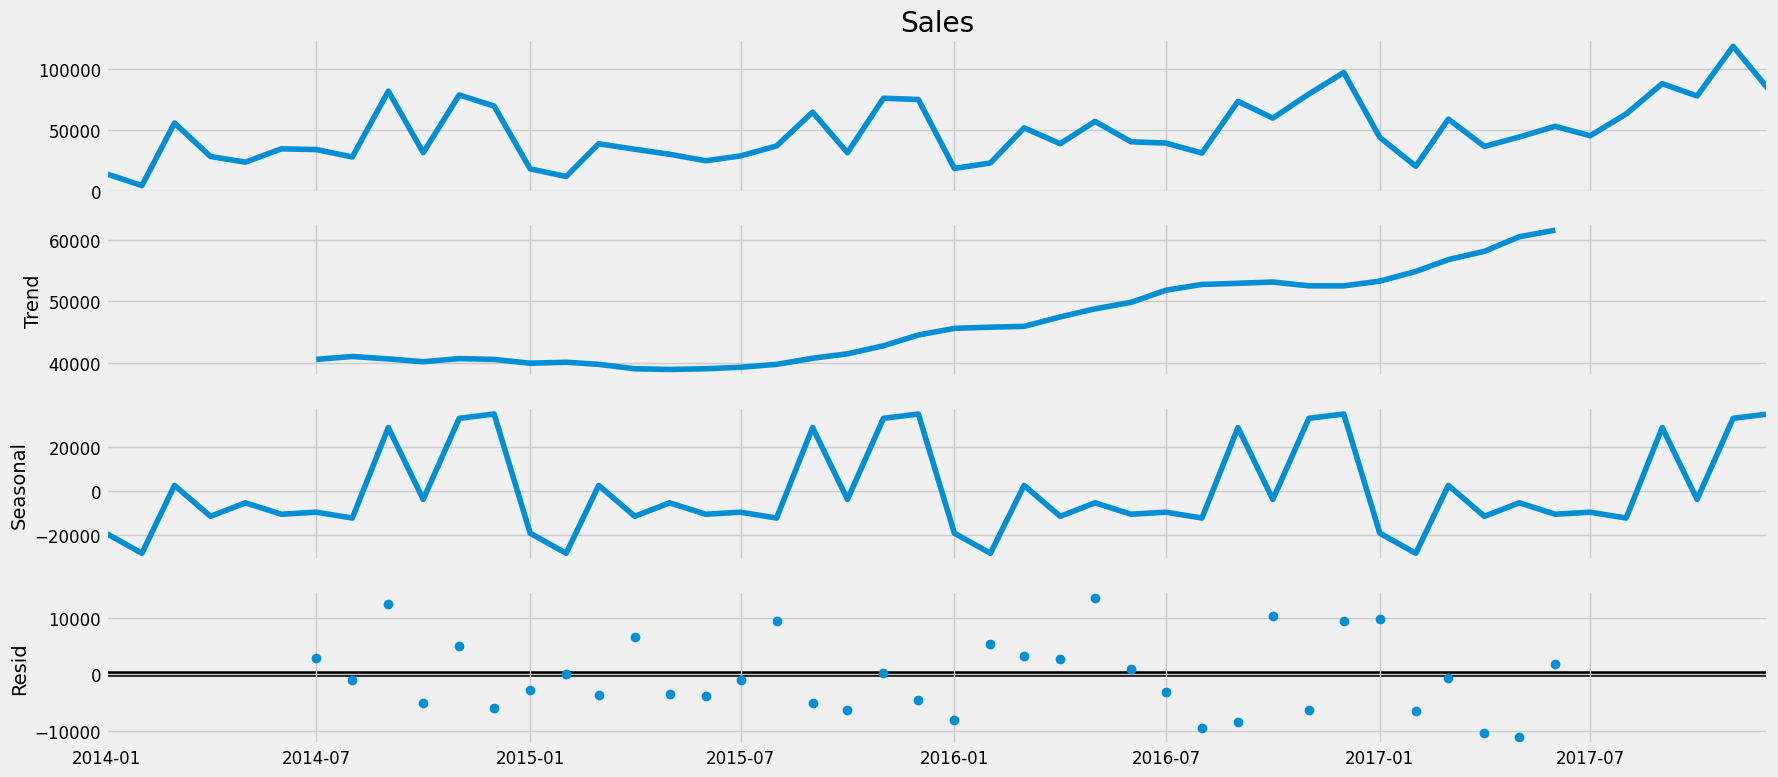

In [34]:
# plot data for trend and seasonality
decomposition = sm.tsa.seasonal_decompose(df3['Sales'], model='additive')
fig = decomposition.plot()

In [37]:
train = df3['Sales'].iloc[:-18]
test = df3['Sales'].iloc[-18:]

ps = range(0, 2)
d=[1] 
qs = range(0, 2)
Ps = range(0, 2)
D=[1] 
Qs = range(0, 2)
s = [12] # season length is still 1
# creating list with all the possible combinations of parameters
parameters = product(ps, d, qs, Ps, D, Qs, s)
parameters_list = list(parameters)
print(len(parameters_list))

result_table = getBestOrder(parameters_list, train, test)

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:706.1901722941462 - RMSE:66645.02110624482
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:395.5427879772018 - RMSE:59795.91334349102
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:115.206702646098 - RMSE:126131.01044188035
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:368.0686774122712 - RMSE:21196.7926360696
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:117.43219195258179 - RMSE:21181.43269650187
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:6.0 - RMSE:21196.7926360696
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:115.55334946298093 - RMSE:27169.568843359124
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:4.0 - RMSE:27169.568843359146
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:6.0 - RMSE:27169.568843359142
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:390.62462764252655 - RMSE:21280.64295445467
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:378.1833144616962 - RMSE:20051.504515787183
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:117.17777000994099 - RMSE:37824.70626634561
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:136.0006169662929 - RMSE:21053.10431331

                                      SARIMAX Results                                       
Dep. Variable:                                Sales   No. Observations:                   30
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -154.268
Date:                              Thu, 25 Apr 2024   AIC                            320.537
Time:                                      09:57:44   BIC                            324.371
Sample:                                  01-01-2014   HQIC                           320.182
                                       - 06-01-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7544      4.885     -0.154      0.877     -10.328       8.820
ma.L1         -0.07

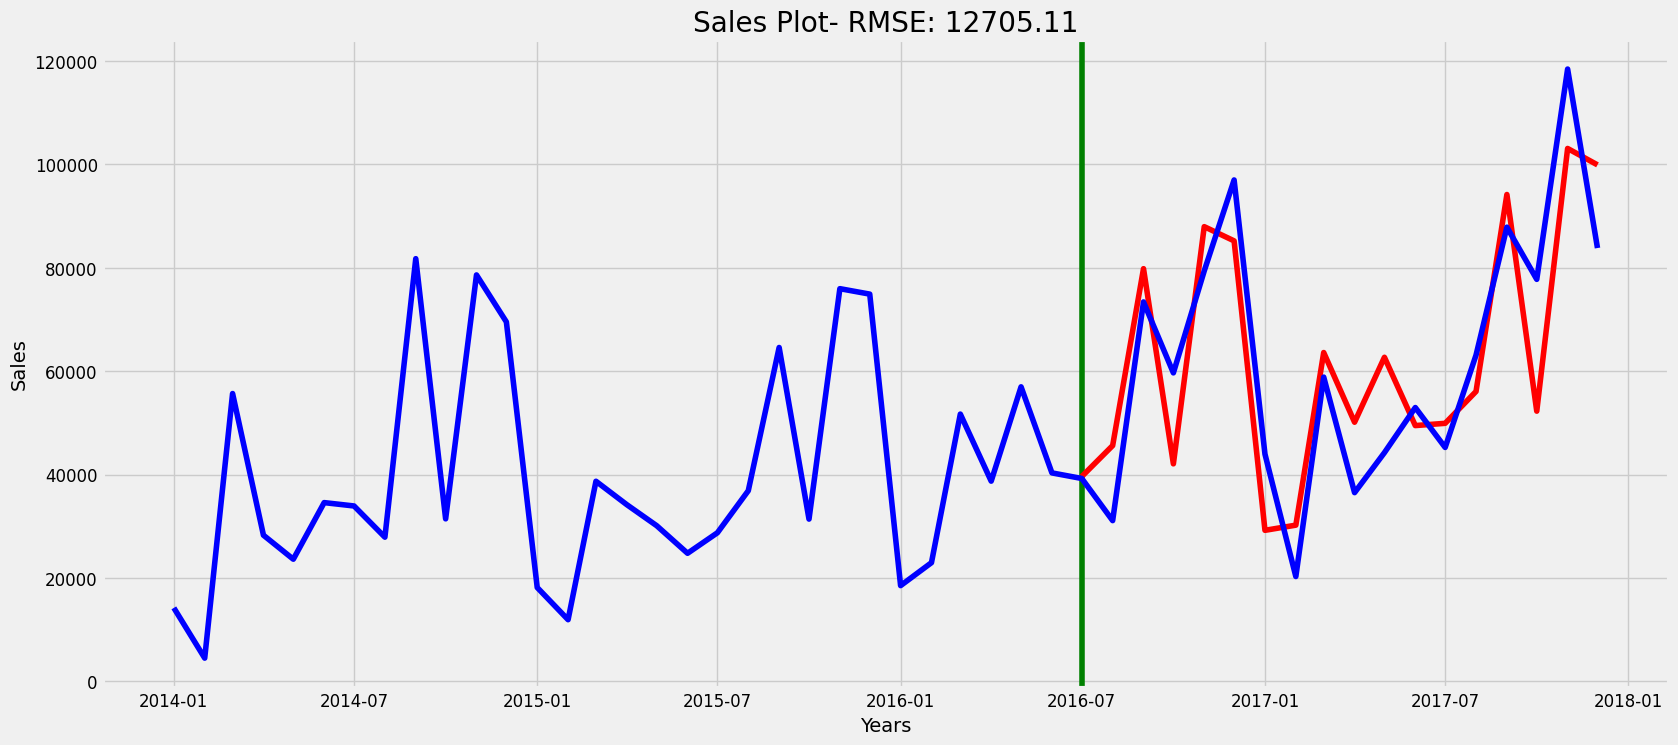

In [39]:
train = df3['Sales'].iloc[:-18]
test = df3['Sales'].iloc[-18:]

model = SARIMAX(train, order=(1,1,2), seasonal_order=(1,0,1,12), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

# define no. of forecasts to be done
K = len(test)

# make forecasts
forecast = model_fit.forecast(K)

plt.xlabel("Years")
plt.ylabel("Sales")
plt.title("Sales Plot- RMSE: %.2f"%np.sqrt(sum((forecast-test)**2)/len(test)))
plt.axvline(x=df3.index[-18], color='green')
plt.plot(forecast, 'r')
plt.plot(df3['Sales'], 'b')
print('RMSE-', np.sqrt(mean_squared_error(test, forecast)))


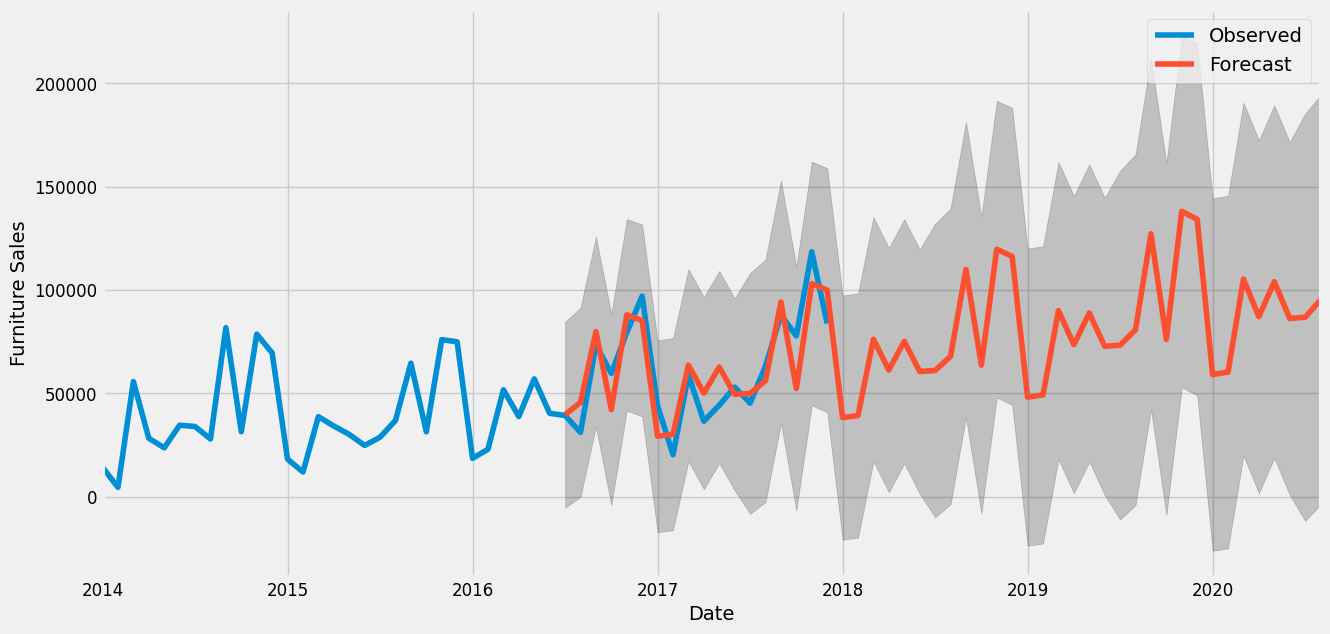

In [40]:
pred_uc = model_fit.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = df3['Sales'].plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

## dataset 4

In [8]:
data = pd.read_csv("data/multiTimeline.csv", skiprows=2,  parse_dates=['Month'], index_col='Month')
data.columns = ['diet', 'gym', 'finance']

gym = data[['gym']]
finance = data[['finance']]
diet = data[['diet']]
diet.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 2004-01-01 to 2017-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   diet    168 non-null    int64
dtypes: int64(1)
memory usage: 2.6 KB


Augmented Dickey-Fuller Test: 
ADF test statistic       -1.647335
p-value                   0.458430
# lags used              13.000000
# observations          154.000000
critical value (1%)      -3.473543
critical value (5%)      -2.880498
critical value (10%)     -2.576878
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


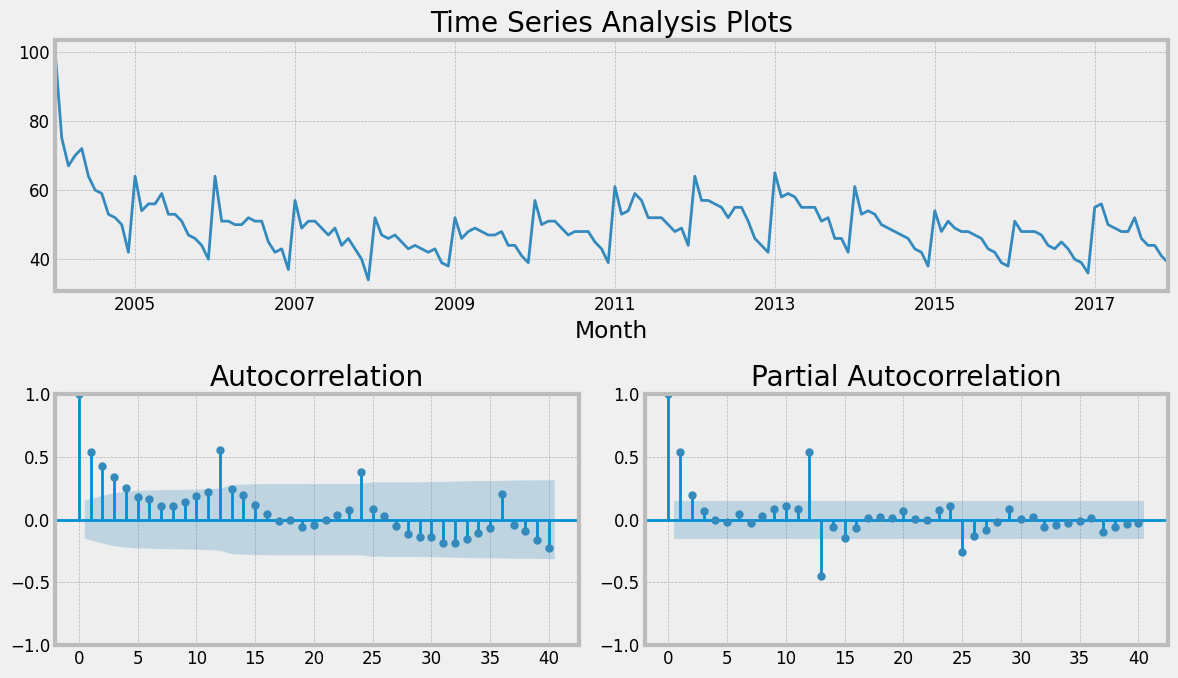

In [3]:
# check variance and trend through first plot
tsplot(data.diet, lags=40)

S=12, p=1, P=1

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.330427
p-value                   0.162342
# lags used              14.000000
# observations          141.000000
critical value (1%)      -3.477601
critical value (5%)      -2.882266
critical value (10%)     -2.577822
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


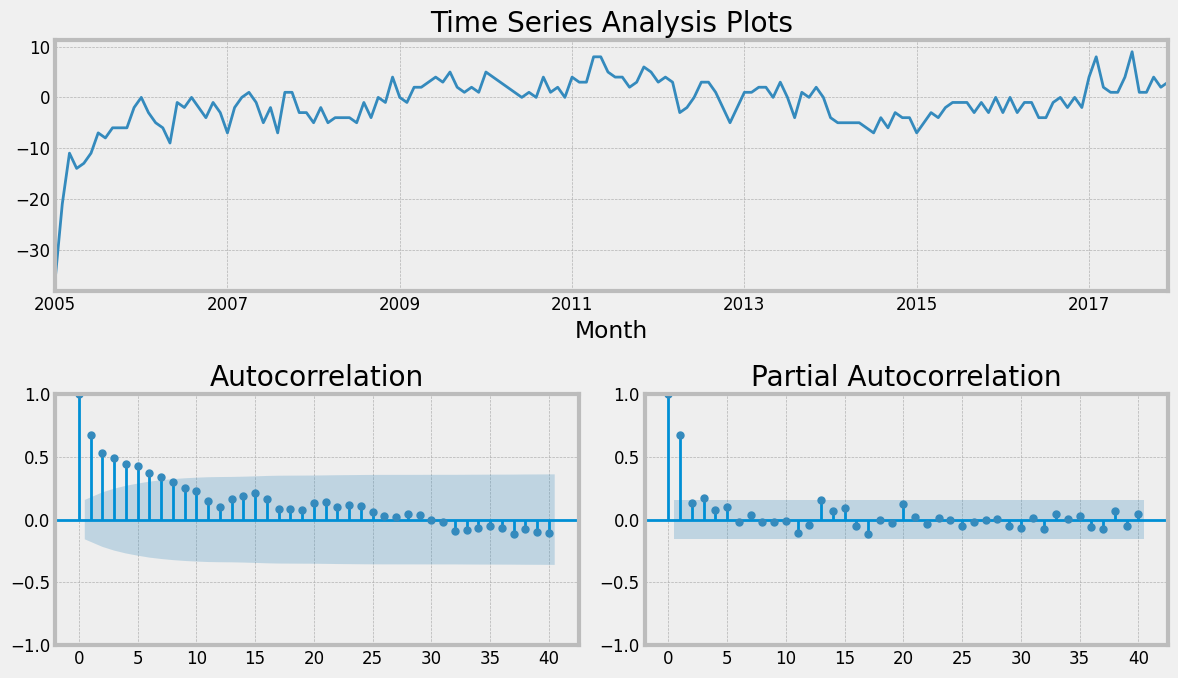

In [4]:
# remove seasonality for 12 months
diet_diff = data.diet.diff(12)
tsplot(diet_diff[12:], lags=40)

autocorrelation function still has too many significant lags, p=1

Augmented Dickey-Fuller Test: 
ADF test statistic       -4.565005
p-value                   0.000150
# lags used              13.000000
# observations          141.000000
critical value (1%)      -3.477601
critical value (5%)      -2.882266
critical value (10%)     -2.577822
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


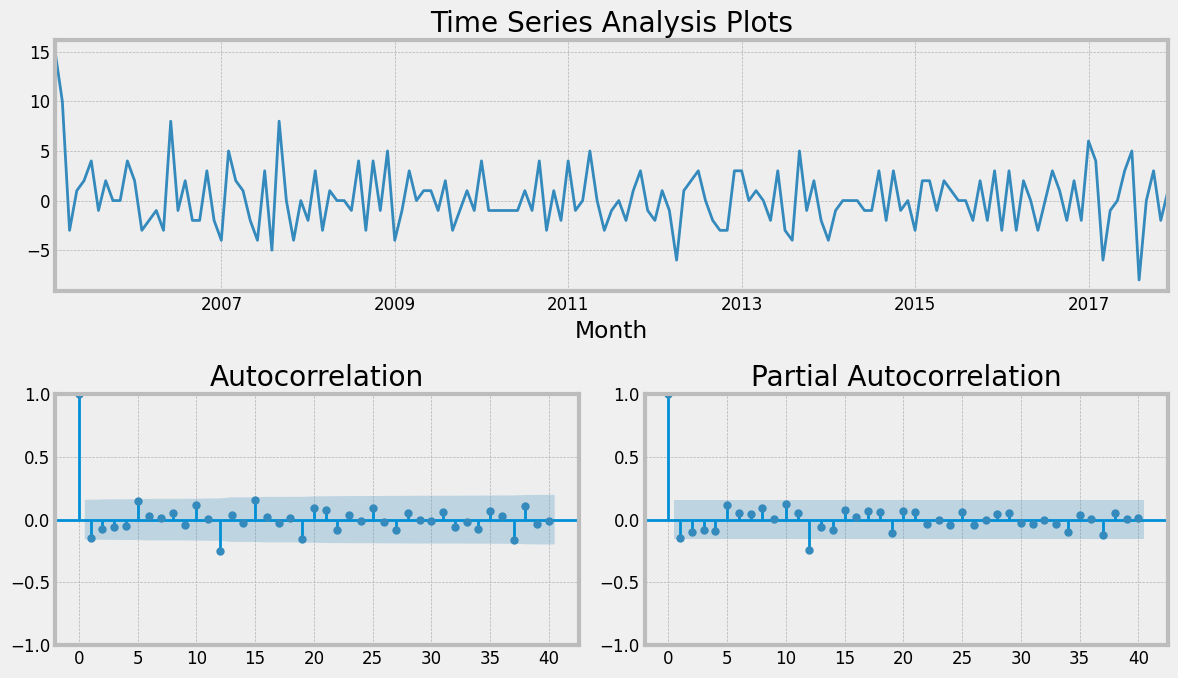

In [5]:
# lets take difference
diet_diff_ = diet_diff.diff(1)
tsplot(diet_diff_[13:], lags=40)

Our series now look like something undescribable, oscillating around zero, Dickey-Fuller indicates that it’s stationary and the number of significant peaks in ACF has dropped<br>

p - 1 (since it’s the last significant lag on PACF after which most others are becoming not significant.)<br>
q - 1 (similar reason but on ACF)<br>
d - 1 (as we had first differences)<br>
P - 1 (since 12th lag is somewhat significant on PACF, while 24th is not)<br>
Q - 1 (same reason but on ACF)<br>
D- 1 (as seasonal difference is required)<br>
S- 12 (12 months seasonality)

In [17]:
ps = range(1, 5)
d=[1] 
qs = range(1, 5)
Ps = range(0, 3)
D=[1] 
Qs = range(0, 2)
s = [12] # season length is still 1
# creating list with all the possible combinations of parameters
parameters = product(ps, d, qs, Ps, D, Qs, s)
parameters_list = list(parameters)
print(len(parameters_list))
    
train = data.diet.iloc[:-24]
test = data.diet.iloc[-24:]

result_table = getBestOrder(parameters_list, train, test)

96


  0%|          | 0/96 [00:00<?, ?it/s]

ARIMA(1, 1, 1, 0, 1, 0, 12) - AIC:602.2285076153444 - RMSE:3.0810115978360617
ARIMA(1, 1, 1, 0, 1, 1, 12) - AIC:521.0158379373732 - RMSE:3.302623908217189
ARIMA(1, 1, 1, 1, 1, 0, 12) - AIC:532.1816026612805 - RMSE:4.215073775304202
ARIMA(1, 1, 1, 1, 1, 1, 12) - AIC:499.38692696533633 - RMSE:2.5990431289402687
ARIMA(1, 1, 1, 2, 1, 0, 12) - AIC:467.3885543607216 - RMSE:4.015025044755779
ARIMA(1, 1, 1, 2, 1, 1, 12) - AIC:469.2750123343071 - RMSE:3.986094506073018
ARIMA(1, 1, 2, 0, 1, 0, 12) - AIC:600.0391763476638 - RMSE:3.137709118301341
ARIMA(1, 1, 2, 0, 1, 1, 12) - AIC:512.1315460487367 - RMSE:2.940578647129868
ARIMA(1, 1, 2, 1, 1, 0, 12) - AIC:534.272749137083 - RMSE:4.552807420028368
ARIMA(1, 1, 2, 1, 1, 1, 12) - AIC:495.86028079985124 - RMSE:2.5873236191142155
ARIMA(1, 1, 2, 2, 1, 0, 12) - AIC:472.34831794087495 - RMSE:4.354646168791666
ARIMA(1, 1, 2, 2, 1, 1, 12) - AIC:452.27977850486747 - RMSE:2.7167917461447395
ARIMA(1, 1, 3, 0, 1, 0, 12) - AIC:597.1549276024174 - RMSE:3.19632059

(3, 1, 4, 2, 1, 1, 12)
                                      SARIMAX Results                                       
Dep. Variable:                                 diet   No. Observations:                  144
Model:             SARIMAX(3, 1, 4)x(2, 1, [1], 12)   Log Likelihood                -313.822
Date:                              Thu, 25 Apr 2024   AIC                            649.644
Time:                                      13:43:29   BIC                            681.271
Sample:                                  01-01-2004   HQIC                           662.495
                                       - 12-01-2015                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7556      1.319      0.573      0.567      -1.830       3.

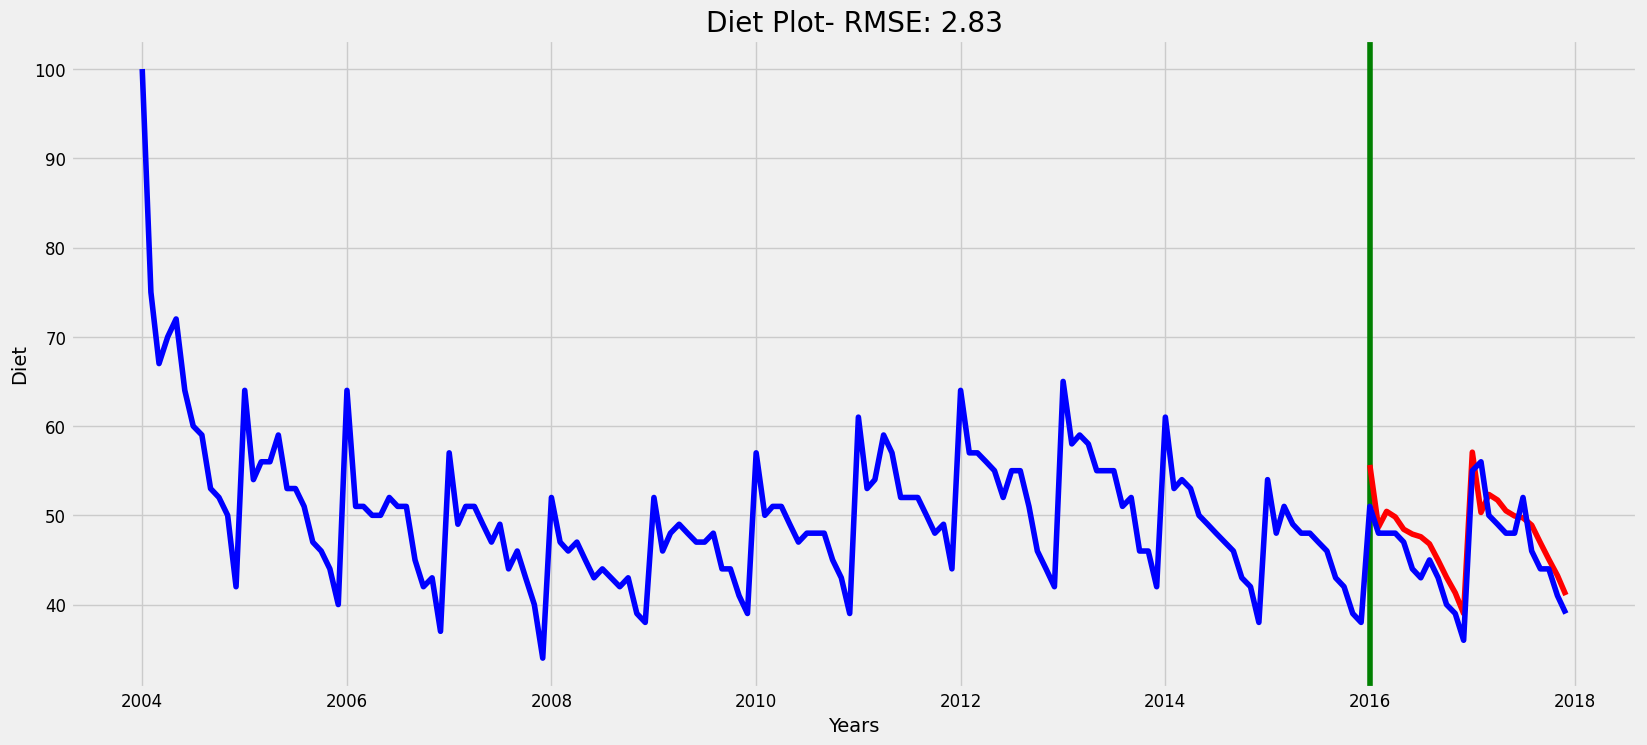

In [24]:
train = data.diet.iloc[:-24]
test = data.diet.iloc[-24:]

# set the parameters that give the lowest AIC/RMSE
print(result_table.parameters[0])
p, d, q, P, D, Q, S = result_table.parameters[0]
best_model = SARIMAX(train, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, S)).fit(disp=False)

print(best_model.summary())

# define no. of forecasts to be done
K = len(test)

# make forecasts
forecast = best_model.forecast(K)

plt.xlabel("Years")
plt.ylabel("Diet")
plt.title("Diet Plot- RMSE: %.2f"%np.sqrt(sum((forecast-test)**2)/len(test)))
plt.axvline(x=data.diet.index[-24], color='green')
plt.plot(forecast, 'r')
plt.plot(data['diet'], 'b')
print('RMSE-', np.sqrt(mean_squared_error(test, forecast)))


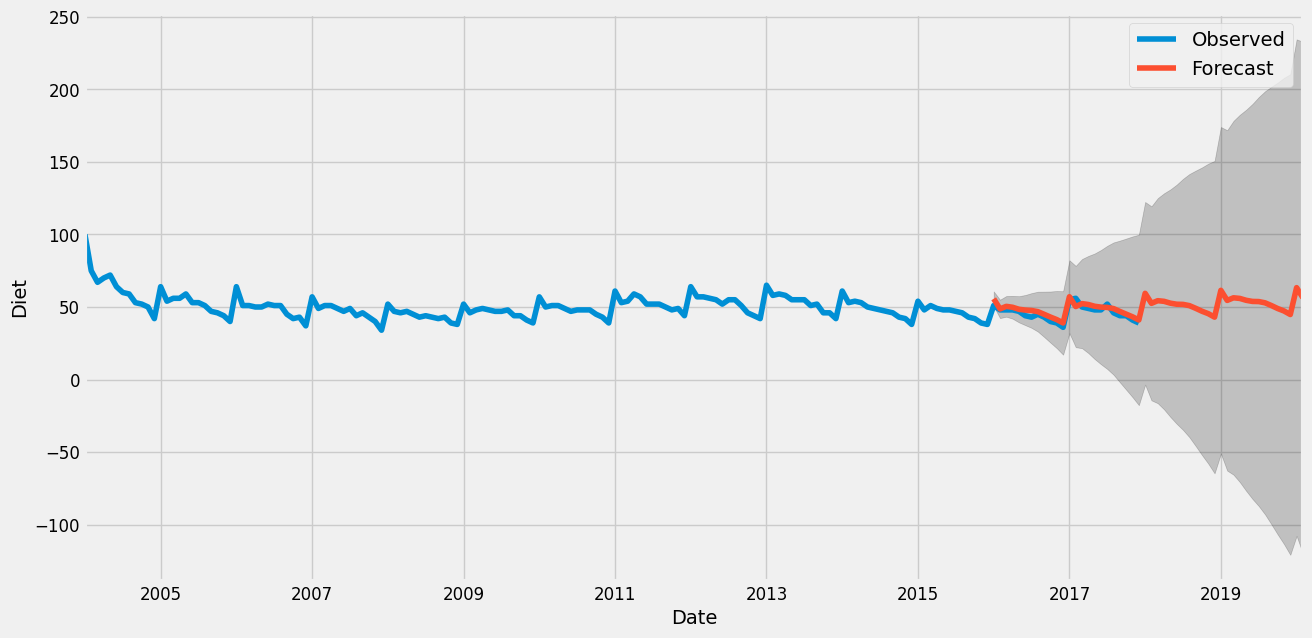

In [25]:
pred_uc = best_model.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()
ax = data.diet.plot(label='Observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Diet')
plt.legend()
plt.show()

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.583307
p-value                   0.000001
# lags used              13.000000
# observations          117.000000
critical value (1%)      -3.487517
critical value (5%)      -2.886578
critical value (10%)     -2.580124
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


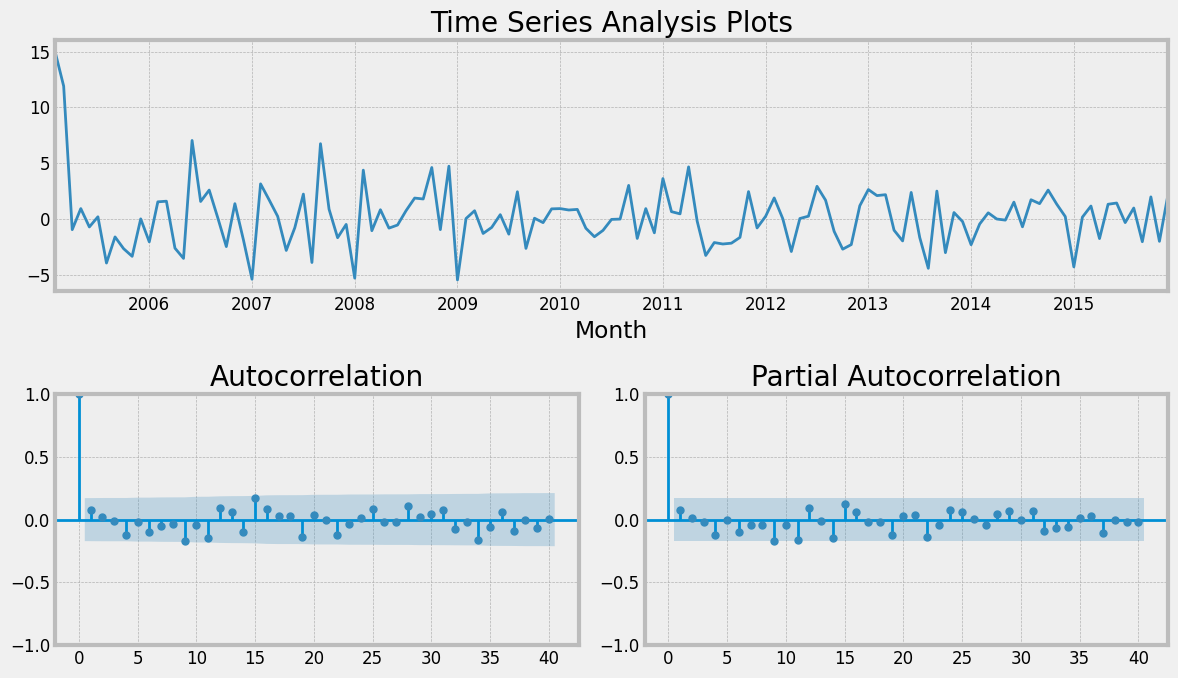

In [26]:
# inspect the residuals of the model
tsplot(best_model.resid[12+1:], lags=40)
# clearly residuals are stationary